In [ ]:
!pip install transformers torch transformers matplotlib Pillow PyMuPDF pdfplumber transformers sentence-transformers faiss-cpu langchain langchain_community langchain_google_genai

In [2]:
import re
import io
import fitz
import pdfplumber
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain.vectorstores import FAISS

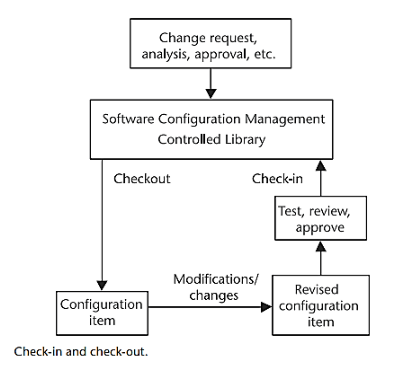

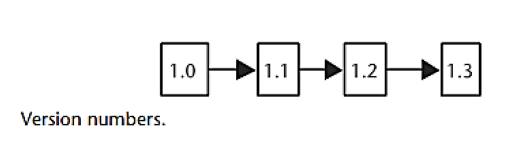

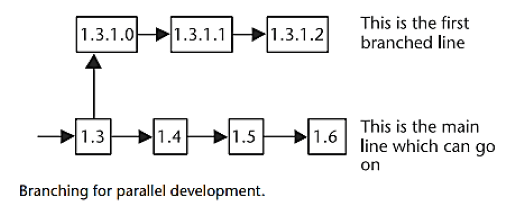

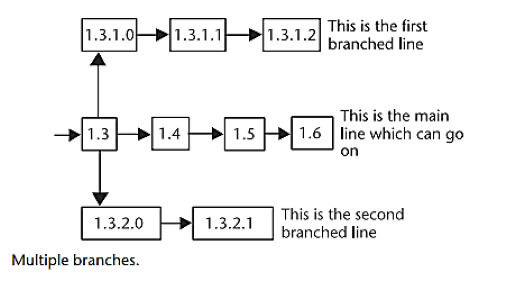

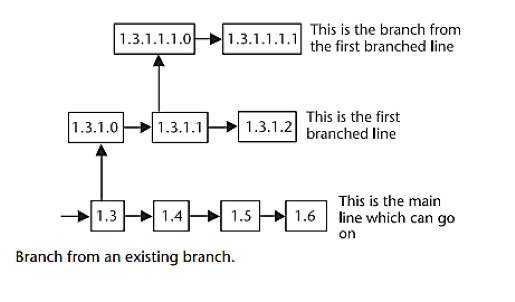

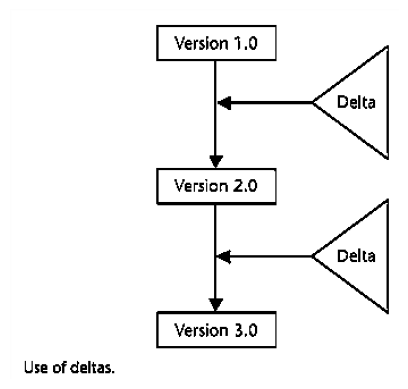

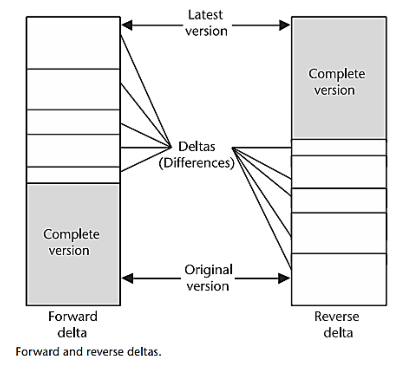

Extracted Text:

Chapter-5
SCM: Basic Concepts
 Overview of SCM
 Baselines
 Check-In and Check-Out
 Versions and Variants
 Parallel Development and Branching
 Naming of Versions
 Source and Derived Items
 System Building
 Releases
 Deltas
 SCM Database
 SCM Activities

SCM: Basic Concepts - Introduction
SCM is the set of activities that are performed throughout the
project life cycle— from requirements analysis to maintenance.
SCM is important because software is subject to constant change—
software systems undergo changes when designed, when built, and
even after being built.
Uncontrolled and unmanaged change can create confusion and
lead to communications breakdown problems, shared data
problems, multiple maintenance problems, simultaneous update
problems, among others. So change has to be controlled and
managed.

SCM Basic concepts
 A software development project produces the following items:
– Programs
• (e.g., source code, object code, executable programs, componen

In [3]:
def extract_text_from_pdf(pdf_path):
    all_text = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                all_text.append(text.strip())

    return "\n\n".join(all_text)

def extract_images_from_pdf(pdf_path):
    images = []
    doc = fitz.open(pdf_path)
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        image_list = page.get_images(full=True)
        for img_index, img in enumerate(image_list):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            images.append(image)
    return images

def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def process_pdf(pdf_path):
    extracted_text = extract_text_from_pdf(pdf_path)
    images = extract_images_from_pdf(pdf_path)
    for image in images:
        display_image(image)
    return extracted_text

pdf_path = 'notes.pdf'
extracted_text = process_pdf(pdf_path)
print(f"Extracted Text:\n\n{extracted_text}")

In [5]:
def calculate_optimal_chunk_size(text):
    avg_sentence_length = sum(len(sentence.split()) for sentence in re.split(r'[.!?]', text)) / max(1, len(re.split(r'[.!?]', text)))
    if avg_sentence_length > 15:
        return 5000
    elif avg_sentence_length > 10:
        return 8000
    else:
        return 12000

def chunk_and_store(text, google_api_key):
    optimal_chunk_size = calculate_optimal_chunk_size(text)
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=optimal_chunk_size, chunk_overlap=1000)
    text_chunks = text_splitter.split_text(text)
    embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=google_api_key)
    vector_store = FAISS.from_texts(text_chunks, embedding=embeddings)
    vector_store.save_local("faiss_index")
    return text_chunks

def concatenate_and_summarize_chunks(text_chunks, model):
    concatenated_texts = []
    temp_chunk = ""
    max_combined_length = 15000
    for chunk in text_chunks:
        if len(temp_chunk) + len(chunk) <= max_combined_length:
            temp_chunk += " " + chunk
        else:
            concatenated_texts.append(temp_chunk.strip())
            temp_chunk = chunk
    if temp_chunk:
        concatenated_texts.append(temp_chunk.strip())
    summarized_chunks = []
    for concatenated_chunk in concatenated_texts:
        prompt = (
                "Summarize the following text in Paragraph while preserving important concepts. "
                + concatenated_chunk
            )
        messages = [{"role": "user", "content": prompt}]
        summary = model.invoke(messages)
        clean_summary = re.sub(r'\*\*(.*?)\*\*|\*(.*?)\*|•', '', summary.content).strip()
        summarized_chunks.append(clean_summary)
    return summarized_chunks

def summarize_text(text_chunks):
    model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.4, google_api_key=google_api_key)
    return concatenate_and_summarize_chunks(text_chunks, model)

def summarize_extracted_text(extracted_text):
    text_chunks = chunk_and_store(extracted_text, google_api_key)
    summarized_chunks = summarize_text(text_chunks)
    formatted_summary = []
    for summary in summarized_chunks:
        clean_summary = re.sub(r'\n+', '\n', summary).strip()
        clean_summary = re.sub(r'\s{2,}', ' ', clean_summary)
        formatted_summary.append(clean_summary)
    return formatted_summary

summaries = summarize_extracted_text(extracted_text)
for summary in summaries:
    print(summary)

combined_summary = "\n".join(summaries)

Software Configuration Management (SCM) involves managing changes to software items throughout the project life cycle. Key concepts include: Items subject to change, such as programs, documentation, and data. Formally designated sets of CIs at specific points in the life cycle, serving as references for subsequent development. Processes for moving CIs into and out of a controlled environment, respectively. Different releases of CIs, with versions representing upgrades or enhancements, and variants representing functionally equivalent versions for different environments. Techniques for allowing multiple developers to work on the same CI simultaneously, creating branches that deviate from the main development line. Version numbers consist of major and minor numbers, while branches have additional parts to indicate the point of divergence from the main line. CIs that are created directly (source) or generated from other CIs (derived). The process of assembling CIs into a complete system. 

In [27]:
model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.4, google_api_key=google_api_key)

def generate_flashcards(text, num_questions=10):
    prompt = f"Frame {num_questions} questions and give their answers based on the following text:\n\n{text}"
    response = model.invoke(prompt)
    response_text = response.content
    qa_pairs = response_text.split("\n")
    flashcards = []
    question = None
    answer = None
    for line in qa_pairs:
        line = line.strip()
        if line.startswith(tuple(f"{i}." for i in range(1, num_questions+1))):
            if question and answer:
                flashcards.append({
                    'question': question,
                    'answer': answer
                })
            question = line.split(".", 1)[-1].strip()
            answer = None
        elif line.startswith("-"):
            answer = line.replace("-", "").strip()
    if question and answer:
        flashcards.append({
            'question': question,
            'answer': answer
        })
    return flashcards

def display_flashcards(flashcards):
    print("Flashcards")
    if not flashcards:
        print("No flashcards generated.")
        return
    for j, card in enumerate(flashcards):
        print(f"\nFlashcard {j + 1}")
        print(f"Q: {card['question']}")
        print(f"A: {card['answer']}")

flashcards = generate_flashcards(combined_summary, num_questions=10)
display_flashcards(flashcards)

Flashcards

Flashcard 1
Q: **What is Software Configuration Management (SCM)?**
A: Answer: Managing changes to software items throughout the project life cycle.

Flashcard 2
Q: **What are key concepts in SCM?**
A: Answer: Items subject to change, configuration items (CIs), controlled environments, releases, versions, branches, source and derived items, system building, releases, deltas, and a CM database.

Flashcard 3
Q: **What is a configuration item (CI)?**
A: Answer: A formally designated set of CIs at specific points in the life cycle, serving as references for subsequent development.

Flashcard 4
Q: **What is a version?**
A: Answer: A release of a CI, with versions representing upgrades or enhancements.

Flashcard 5
Q: **What is a variant?**
A: Answer: A release of a CI that is functionally equivalent to another version but designed for a different environment.

Flashcard 6
Q: **What is branching in SCM?**
A: Answer: A technique for allowing multiple developers to work on the same

In [28]:
def generate_mcq_questions(text, num_questions=10):
    prompt = (
        f"Create {num_questions} multiple-choice questions based on the following text {text}. "
        "For each question, provide 4 options (a, b, c, d) and mark the correct one. "
        "Ensure that each question and its options are displayed on separate lines:\n\n. Provide the answer key too"
    )
    response = model.invoke(prompt)
    response_text = response.content
    print("MCQ Questions\n")
    lines = response_text.split('\n')
    for line in lines:
        print(line.strip())

generate_mcq_questions(text = combined_summary)

MCQ Questions

**Question 1:**
Which of the following is NOT a key concept in Software Configuration Management (SCM)?
(a) Items subject to change
(b) Formally designated sets of CIs
(c) Processes for moving CIs into a controlled environment
(d) Techniques for allowing multiple developers to work on the same CI simultaneously

**Question 2:**
What is the purpose of a baseline in SCM?
(a) To serve as a reference for subsequent development
(b) To allow multiple developers to work on the same CI simultaneously
(c) To store information about CIs, their relationships, and their history
(d) To specify the components, versions, and build parameters for system building

**Question 3:**
What is the difference between a version and a variant?
(a) Versions represent upgrades or enhancements, while variants represent functionally equivalent versions for different environments.
(b) Variants represent upgrades or enhancements, while versions represent functionally equivalent versions for different e